# Exploring parameters

#### density plots, post predictive checks etc.

In [1]:
%load_ext autoreload
%autoreload 2
import os.path as op
import tempfile

import matplotlib.pyplot as plt


import hnn_core
from hnn_core import simulate_dipole, jones_2009_model
from hnn_core.viz import plot_dipole


import sys
sys.path.append('../code/')
sys.path.append('../code/utils/')
#sys.path.append('../code/sbi/')
#sys.path.append('../../results_cluster/')


import numpy as np
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt


import os

work_dir = '/home/ubuntu/sbi_for_eeg_data/code/'

os.chdir(work_dir)

#from utils.plot import cov, compare_vars, plot_varchanges
#from utils.plot import compare_KLs, plot_KLs
#from sbi.inference import potentials
import utils.sbi_modulated_functions

# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

from sbi.analysis import conditional_pairplot, conditional_corrcoeff



# import the summary statistics that you want to investigate
from summary_features.calculate_summary_features import calculate_summary_statistics_alternative as alternative_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal as temporal_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_number as number_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal


In [2]:
print(torch.__version__)

1.11.0


In [3]:
## defining neuronal network model

num_params = 6

from utils.simulation_wrapper import set_network_default, SimulationWrapper
sim_wrapper = SimulationWrapper(num_params, noise=False)


In [13]:
from utils import inference

import pickle
from data_load_writer import *
from data_load_writer import load_from_file as lf

import os

work_dir = '/home/ubuntu/'

os.chdir(work_dir)



import os

print(os.getcwd())



#file = 'toy_example_maf_08_04_lesser_ratio'
file ='toy_example_version2_maf_2_05'


os.chdir('results/{}'.format(file))


print(os.getcwd())
  



/home/ubuntu
/home/ubuntu/results/toy_example_version2_maf_2_05


In [14]:
def Gaussian(thetas, normal_noise=1):
    
    gauss_list = []
    
    for theta in thetas:
    
        mu, sigma = theta, normal_noise # mean and standard deviation

        s = np.random.normal(mu, sigma, 1)
    
        
        gauss_list.append(s[0])
        
    gauss_obs = torch.tensor(gauss_list)
    
    return gauss_obs
    



In [15]:
list_collection = torch.load('list_collection.pt')
list_collection_inc = torch.load('list_collection_inc.pt')

In [16]:
true_thetas = torch.tensor([[3.0, 6.0, 20.0, 10.0, 90.0, 55.0, 27.0, 27.0, 4.0, 70.0, 5.0, 66.0, 99.0, 40.0, 45.0]])
parameter_names = ['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10', 't11', 't12', 't13', 't14', 't15']

prior_max = [100.0] * 15
prior_min = [1.0] * 15

prior = utils.torchutils.BoxUniform(low=prior_min, high = prior_max)

samples_prior = prior.sample((10000,))

simulator_stats, prior = prepare_for_sbi(Gaussian, prior)

In [17]:
samples_prior_list = samples_prior.unsqueeze(0)

In [18]:
samples_prior_list[0].shape

torch.Size([10000, 15])

In [19]:
thetas = inference.run_only_sim(samples_prior_list, simulation_wrapper = simulator_stats, num_workers=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished


In [20]:
def KL_Gauss(X, Y):
    
    sample_x = X.sample((1000,))
    mu_x = torch.mean(sample_x, dim=0)
    var_x = torch.std(sample_x, dim=0)

    var_y = Y.stddev

    mu_y = Y.mean
    
    
    return torch.mean(np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2)), var_x, mu_x


def calc_KL_1d(X, Y):
    
    sample_x = X.sample((1000,))
    mu_x = torch.mean(sample_x, dim=0)
    var_x = torch.std(sample_x, dim=0)
    
    print(var_x)
    print(mu_x)


    var_y = Y.stddev

    mu_y = Y.mean
    
    print(mu_y)
    print(var_y)
    
    print(np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2))
    
    return np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2)


# calculate the jensen-shanon divergence
def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

In [21]:

analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_snpe_list = []

variance_list_snpe = []

mean_list_snpe = []


## for round
for posterior_snpe_list in list_collection:
    
    KL_snpe = []
    KL_snpe_1d = []
    
    
    ## for number of simulations
    for posterior_snpe in posterior_snpe_list:


        #KL = KLdivergence(posterior_snpe, sample_y)
        KL, var_x, mu_x = KL_Gauss(posterior_snpe, analytic)
        
        variance_list_snpe.append(var_x)
        
        mean_list_snpe.append(mu_x)


        KL_1d = calc_KL_1d(posterior_snpe, analytic)

        KL_snpe_1d.append(KL_1d)

        #KL_snpe_sum.append(sum_KL)

        KL_snpe.append(KL)
        
    overall_snpe_list.append(KL_snpe)


    
    

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.147
acceptance rate:  0.15218181818181817


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.141
acceptance rate:  0.15154545454545454
tensor([5.0654, 5.8595, 5.4421, 4.8968, 7.6554, 2.9699, 4.1643, 5.0113, 3.9259,
        3.1575, 5.5802, 3.0381, 5.1311, 3.5390, 2.9495])
tensor([ 9.2434, 11.7151, 23.2982, 10.3725, 81.5476, 52.1048, 30.7670, 33.5843,
         6.9966, 69.9213, 10.9770, 62.8305, 90.9905, 40.2718, 40.0386])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[30.1964, 31.2299, 18.0530,  9.9701, 62.4885,  7.0126, 13.8391, 32.1216,
         10.3286,  3.3381, 31.2125,  8.0267, 43.1043,  4.5352, 15.0757]])


In [22]:
torch.manual_seed(5)
np.random.seed(5)

obs_real = Gaussian(true_thetas[0, 0:])



analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_incremental_list = []

variance_list_less = []

mean_list_less = []

for posterior_incremental_list in list_collection_inc:
    
    KL_incremental = []

    for posterior_incremental in posterior_incremental_list:

        posterior_incremental.set_default_x(obs_real)

        #KL = KLdivergence(posterior_incremental, sample_y)

        KL, var_x, mu_x = KL_Gauss(posterior_incremental, analytic)
        
        variance_list_less.append(var_x)
        mean_list_less.append(mu_x)

        #KL_1d = calc_KL_1d(posterior_incremental, analytic)

        #KL_incremental_1d.append(KL_1d)


        KL_incremental.append(KL)

        
    overall_incremental_list.append(KL_incremental)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


In [106]:
print(os.getcwd())
#file = 'toy_example_maf_05_04_no_ratio'
#file = 'toy_example_maf_29_04_noratio_5'
#file = 'toy_example_maf_29_04_noratio_more_sims2'
#file ='toy_example_version2_maf_2_05'
file ='toy_example_version2_maf_02_05_long'



os.chdir('/home/ubuntu/results/{}'.format(file))

/home/ubuntu/results/toy_example_maf_13_04_greater_ratio


In [107]:
list_collection_inc = torch.load('list_collection_inc.pt')
list_collection = torch.load('list_collection.pt')

In [108]:
list_collection

[[DirectPosterior(
                 method_family=snpe,
                 net=<a Flow, see `.net` for details>,
                 prior=BoxUniform(Uniform(low: torch.Size([15]), high: torch.Size([15])), 1),
                 x_shape=torch.Size([1, 15]))
                 ,
  DirectPosterior(
                 method_family=snpe,
                 net=<a Flow, see `.net` for details>,
                 prior=BoxUniform(Uniform(low: torch.Size([15]), high: torch.Size([15])), 1),
                 x_shape=torch.Size([1, 15]))
                 ,
  DirectPosterior(
                 method_family=snpe,
                 net=<a Flow, see `.net` for details>,
                 prior=BoxUniform(Uniform(low: torch.Size([15]), high: torch.Size([15])), 1),
                 x_shape=torch.Size([1, 15]))
                 ,
  DirectPosterior(
                 method_family=snpe,
                 net=<a Flow, see `.net` for details>,
                 prior=BoxUniform(Uniform(low: torch.Size([15]), high: torch.Si

In [148]:
file = 'toy_example_maf_29_04_noratio_more_sims2'
file = 'toy_example_maf_05_04_no_ratio'


os.chdir('/home/ubuntu/results/{}'.format(file))

In [149]:
list_collection_inc_greater_ratio = torch.load('list_collection_inc.pt')

#obs_real = torch.load('obs_real.pt')

In [111]:
analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_incremental_list_ratio = []

variance_list_inc = []

mean_list_inc = []

for posterior_incremental_list in list_collection_inc:
    
    KL_incremental = []

    for posterior_incremental in posterior_incremental_list:

        #posterior_incremental.set_default_x(obs_real)

        #KL = KLdivergence(posterior_incremental, sample_y)

        KL, var_x, mu_x = KL_Gauss(posterior_incremental, analytic)
        
        variance_list_inc.append(var_x)
        mean_list_inc.append(mu_x)

        #KL_1d = calc_KL_1d(posterior_incremental, analytic)

        #KL_incremental_1d.append(KL_1d)


        KL_incremental.append(KL)

        
    overall_incremental_list_ratio.append(KL_incremental)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


In [194]:

analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_snpe_list = []

variance_list_snpe = []

mean_list_snpe = []


## for round
for posterior_snpe_list in list_collection:
    
    KL_snpe = []
    KL_snpe_1d = []
    
    
    ## for number of simulations
    for posterior_snpe in posterior_snpe_list:


        #KL = KLdivergence(posterior_snpe, sample_y)
        KL, var_x, mu_x = KL_Gauss(posterior_snpe, analytic)
        
        variance_list_snpe.append(var_x)
        
        mean_list_snpe.append(mu_x)


        KL_1d = calc_KL_1d(posterior_snpe, analytic)

        KL_snpe_1d.append(KL_1d)

        #KL_snpe_sum.append(sum_KL)

        KL_snpe.append(KL)
        
    overall_snpe_list.append(KL_snpe)


    
    

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.079
acceptance rate:  0.07436363636363637
acceptance rate:  0.07347619047619047


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.075
acceptance rate:  0.06936363636363636
acceptance rate:  0.07314285714285715
tensor([4.2504, 6.0483, 4.6500, 4.5041, 5.2287, 2.4796, 4.6021, 4.0515, 5.0177,
        5.2864, 4.1478, 3.4698, 5.2847, 3.1849, 3.0560])
tensor([ 6.8633, 10.8389, 30.2830,  9.3473, 87.7256, 54.2287, 24.4083, 26.2937,
         8.3576, 68.3945,  7.1847, 62.8553, 92.6500, 39.7768, 46.7104])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[14.5484, 27.6986, 61.6447,  8.3515, 14.1020,  1.9636, 11.9216,  6.5576,
         19.9702, 13.0966,  9.0658,  9.2201, 31.9605,  3.4383,  4.5153]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.013
acceptance rate:  0.011
acceptance rate:  0.012095238095238095
acceptance rate:  0.013225806451612903
acceptance rate:  0.013097560975609756
acceptance rate:  0.013294117647058824
acceptance rate:  0.013229508196721312
acceptance rate:  0.013183098591549296
acceptance rate:  0.013358024691358024


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.007
acceptance rate:  0.011
acceptance rate:  0.011761904761904762
acceptance rate:  0.011548387096774193
acceptance rate:  0.01175609756097561
acceptance rate:  0.01203921568627451
acceptance rate:  0.01221311475409836
acceptance rate:  0.012352112676056338
acceptance rate:  0.012246913580246913
acceptance rate:  0.012153846153846154
tensor([2.6308, 3.5167, 4.6977, 4.3400, 3.6560, 2.8149, 3.1788, 2.8618, 3.8759,
        3.8893, 3.9680, 2.3113, 3.0951, 2.3927, 2.2277])
tensor([ 4.4787,  6.0326, 12.3868, 10.0438, 93.8520, 59.6838, 22.9430, 29.5960,
        10.9213, 67.9369,  7.0181, 67.7147, 95.8690, 39.7582, 44.2940])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 3.0865,  4.4265, 37.9670,  7.4510, 12.3057, 13.3959, 11.6255,  5.9130,
         29.6090,  7.8333,  8.0307,  2.8034,  8.0616,  1.5192,  1.4296]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.01


                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 898 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.009272727272727273
acceptance rate:  0.00819047619047619
acceptance rate:  0.008193548387096775
acceptance rate:  0.007878048780487805
acceptance rate:  0.007705882352941176
acceptance rate:  0.007934426229508197
acceptance rate:  0.007943661971830987
acceptance rate:  0.007901234567901235
acceptance rate:  0.007923076923076923
acceptance rate:  0.00796039603960396
acceptance rate:  0.007927927927927928
acceptance rate:  0.007950413223140496
acceptance rate:  0.007938931297709924


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.012


                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 912 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.008
acceptance rate:  0.00780952380952381
acceptance rate:  0.007935483870967742
acceptance rate:  0.007902439024390244
acceptance rate:  0.007764705882352941
acceptance rate:  0.007639344262295082
acceptance rate:  0.007816901408450705
acceptance rate:  0.007802469135802469
acceptance rate:  0.007692307692307693
acceptance rate:  0.00793069306930693
acceptance rate:  0.00781981981981982
acceptance rate:  0.00787603305785124
acceptance rate:  0.007793893129770992
tensor([2.7781, 3.4060, 4.8861, 4.4889, 4.2592, 2.2856, 3.4060, 3.4666, 3.9064,
        2.5608, 4.5645, 2.8408, 3.5885, 2.4208, 2.6422])
tensor([ 4.4146,  5.8896, 18.0546, 21.6863, 92.4302, 55.5278, 30.9413, 31.5941,
         6.9772, 71.8974,  8.4918, 63.8588, 94.5585, 36.2342, 42.5473])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 3.3377,  4.0811, 11.7430, 76.3580, 10.0743,  1.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.077
acceptance rate:  0.08272727272727273
acceptance rate:  0.08257142857142857


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.075
acceptance rate:  0.07709090909090908
acceptance rate:  0.08038095238095239
tensor([4.1255, 3.6716, 2.6281, 4.4881, 3.5069, 2.3284, 3.3711, 2.7431, 4.5134,
        2.3052, 4.1089, 2.4665, 3.2760, 2.3398, 2.1026])
tensor([ 8.8016,  7.2062, 24.0828, 16.1508, 86.0267, 57.3791, 30.4803, 26.0596,
         9.5077, 70.6757,  7.4865, 65.1092, 95.7974, 38.4762, 45.2020])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[23.4221,  5.6674, 10.3216, 26.9863, 12.2882,  4.1957, 10.0230,  2.6954,
         23.3455,  1.5501,  9.6197,  2.0357,  8.8077,  2.5483,  0.9877]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.18
acceptance rate:  0.17263636363636364


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.184
acceptance rate:  0.17927272727272728
tensor([4.1202, 4.7797, 4.0722, 4.2134, 3.7907, 2.0291, 2.9755, 2.8011, 2.7419,
        2.9241, 3.3704, 2.4069, 4.1540, 2.1269, 2.0552])
tensor([ 9.3837, 13.3997, 24.6421, 11.6119, 87.5058, 54.9579, 29.8084, 25.5226,
         8.9052, 67.6223,  5.9900, 64.2451, 94.4685, 38.9738, 48.1116])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[26.9478, 36.7366, 17.1618,  8.2373,  8.4629,  0.8519,  6.7798,  3.4845,
         14.2810,  5.5290,  4.4547,  3.0579, 16.9711,  1.5336,  5.7327]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.498
acceptance rate:  0.5296363636363637


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.517
acceptance rate:  0.5318181818181819
tensor([8.1164, 5.6013, 2.9199, 3.4507, 4.1962, 2.1991, 3.2705, 3.1551, 4.5765,
        3.2027, 5.6519, 2.9211, 7.3558, 2.0517, 1.7417])
tensor([18.2101,  9.1198, 20.1418, 10.2035, 84.5293, 57.6388, 27.9606, 29.5293,
         9.5327, 68.1335, 13.5269, 61.8515, 84.5572, 36.7012, 44.6735])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[146.0173,  18.3310,   2.7013,   4.2358,  21.8342,   4.6115,   4.1245,
           6.5269,  23.7562,   5.2065,  50.0936,  11.2994, 128.8558,   6.3271,
           0.5152]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.104
acceptance rate:  0.1139090909090909


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.099
acceptance rate:  0.108
tensor([5.2309, 3.2043, 4.4426, 6.3123, 4.5327, 2.6077, 3.8195, 4.1462, 5.5252,
        3.2110, 4.8451, 2.7589, 4.8485, 3.1231, 3.0434])
tensor([10.3482,  4.9506, 24.6054, 17.8262, 87.5474, 54.9472, 29.5037, 27.2489,
        10.1503, 67.5918, 10.2425, 60.8206, 90.4670, 44.5518, 43.5986])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[38.5248,  4.0199, 18.4818, 48.2050, 11.2692,  1.9430,  8.5884,  6.7043,
         31.9673,  6.3883, 23.4015, 15.7042, 46.0815, 13.5974,  3.9999]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.371
acceptance rate:  0.37227272727272726


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.34
acceptance rate:  0.36463636363636365
tensor([4.8301, 4.0553, 3.3529, 4.0170, 3.7177, 2.4370, 3.2912, 2.9333, 4.3567,
        2.3121, 5.1137, 2.1145, 3.8044, 1.9472, 1.9987])
tensor([10.6215,  7.1530, 20.8900, 12.0165, 86.3668, 54.8784, 31.7477, 28.8673,
        13.9875, 69.3867, 14.4336, 60.3198, 94.1704, 40.1885, 45.4770])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[38.6338,  6.9872,  4.3073,  8.2107, 11.6975,  1.5861, 14.9951,  4.4694,
         57.3939,  1.5227, 55.4393, 17.1189, 17.0628,  0.7472,  0.9186]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.003


                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 943 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.0051818181818181815
acceptance rate:  0.005333333333333333
acceptance rate:  0.00567741935483871
acceptance rate:  0.005463414634146341
acceptance rate:  0.005431372549019608
acceptance rate:  0.0051147540983606556
acceptance rate:  0.0050704225352112674
acceptance rate:  0.0050987654320987655
acceptance rate:  0.00510989010989011
acceptance rate:  0.0050594059405940596
acceptance rate:  0.005081081081081081
acceptance rate:  0.005082644628099173
acceptance rate:  0.005061068702290076
acceptance rate:  0.004943262411347518
acceptance rate:  0.004874172185430464
acceptance rate:  0.004850931677018633
acceptance rate:  0.0048771929824561406
acceptance rate:  0.004917127071823205
acceptance rate:  0.004910994764397905
acceptance rate:  0.004870646766169154
acceptance rate:  0.004834123222748815


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.005


                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 945 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.005
acceptance rate:  0.004857142857142857
acceptance rate:  0.004967741935483871
acceptance rate:  0.004780487804878049
acceptance rate:  0.004980392156862745
acceptance rate:  0.005
acceptance rate:  0.004887323943661972
acceptance rate:  0.004802469135802469
acceptance rate:  0.004802197802197802
acceptance rate:  0.0048415841584158415
acceptance rate:  0.004873873873873874
acceptance rate:  0.004892561983471075
acceptance rate:  0.004946564885496183
acceptance rate:  0.004971631205673759
acceptance rate:  0.004874172185430464
acceptance rate:  0.004807453416149068
acceptance rate:  0.004830409356725146
acceptance rate:  0.004856353591160221
acceptance rate:  0.004837696335078534
acceptance rate:  0.004845771144278607
acceptance rate:  0.004843601895734597
tensor([2.7545, 3.3585, 4.5557, 3.3861, 4.4003, 2.1477, 3.2742, 3.4110, 2.0934,
        3.0276, 3.1640, 2.6842, 4.1020, 4.1814, 2.2605])
tensor([ 4.2267,  5.4786, 18.8977, 11.7220, 91.4414, 54.9725, 24.6960, 27

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.129
acceptance rate:  0.11445454545454545


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.116
acceptance rate:  0.11527272727272728
tensor([3.7393, 3.5160, 3.2393, 4.5930, 4.2313, 2.0474, 3.2736, 3.2964, 4.4271,
        2.6826, 5.3742, 2.3108, 2.8138, 2.3528, 1.9941])
tensor([ 6.9405,  5.5982, 22.5867, 12.3251, 92.0121, 55.3712, 27.4087, 31.4884,
         9.4465, 69.9950, 10.1455, 63.5555, 96.3470, 40.8661, 46.2362])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[12.9358,  4.5044,  6.9167, 11.2264,  9.0337,  0.9482,  3.7558, 13.8131,
         22.6443,  2.1113, 25.4974,  4.3202,  5.9434,  1.7873,  1.5621]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.253
acceptance rate:  0.24163636363636365


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.224
acceptance rate:  0.2431818181818182
tensor([3.2191, 3.5160, 2.7898, 4.1017, 3.6712, 1.4288, 3.5188, 2.5404, 3.1518,
        2.7862, 4.3230, 1.9236, 2.7962, 2.1683, 2.4162])
tensor([ 6.4010,  6.6703, 18.3170, 10.2153, 91.4042, 55.6915, 29.2927, 27.6647,
         9.6779, 65.1320, 10.1315, 64.9642, 96.2202, 41.7289, 44.5368])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 9.2954,  4.6486,  3.7818,  6.5237,  5.9240,  0.4030,  7.0612,  2.0155,
         19.4382, 14.2055, 20.5462,  1.2324,  6.2448,  2.5714,  1.6442]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.0


                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 1000 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance

acceptance rate:  2.117746717492588e-06
acceptance rate:  2.108814846056516e-06
acceptance rate:  2.099958000839983e-06
acceptance rate:  2.0911752404851525e-06
acceptance rate:  2.082465639316951e-06
acceptance rate:  2.073828287017835e-06
acceptance rate:  2.0652622883106154e-06
acceptance rate:  2.0567667626491155e-06
acceptance rate:  2.0483408439164278e-06
acceptance rate:  2.039983680130559e-06
acceptance rate:  2.0316944331572534e-06
acceptance rate:  2.0234722784297856e-06
acceptance rate:  2.015316404675534e-06
acceptance rate:  2.007226013649137e-06
acceptance rate:  1.999200319872051e-06
acceptance rate:  1.9912385503783353e-06
acceptance rate:  1.9833399444664816e-06
acceptance rate:  1.9755037534571318e-06
acceptance rate:  1.967729240456513e-06
acceptance rate:  1.960015680125441e-06
acceptance rate:  1.952362358453729e-06
acceptance rate:  2.333722287047841e-06
acceptance rate:  2.324680356450988e-06
acceptance rate:  2.3157082207641837e-06
acceptance rate:  2.3068050749

acceptance rate:  2.2825838849577723e-06
acceptance rate:  2.277385561375541e-06
acceptance rate:  2.272210861167916e-06
acceptance rate:  2.2670596236681024e-06
acceptance rate:  2.2619316896629722e-06
acceptance rate:  2.2568269013766643e-06
acceptance rate:  2.251745102454402e-06
acceptance rate:  2.246686137946529e-06
acceptance rate:  2.2416498542927596e-06
acceptance rate:  2.236636099306643e-06
acceptance rate:  2.231644722160232e-06
acceptance rate:  2.22667557336896e-06
acceptance rate:  2.2217285047767164e-06
acceptance rate:  2.216803369541122e-06
acceptance rate:  2.2119000221190003e-06
acceptance rate:  2.2070183182520414e-06
acceptance rate:  2.2021581149526535e-06
acceptance rate:  2.197319270490002e-06
acceptance rate:  2.192501644376233e-06
acceptance rate:  2.187705097352877e-06
acceptance rate:  2.1829294913774284e-06
acceptance rate:  2.1781746896101065e-06
acceptance rate:  2.1734405564007825e-06
acceptance rate:  2.168726957276079e-06
acceptance rate:  2.164033758

acceptance rate:  2.8076743097800654e-06
acceptance rate:  2.8033016664071016e-06
acceptance rate:  2.7989426216762558e-06
acceptance rate:  2.7945971122496507e-06
acceptance rate:  2.7902650751821424e-06
acceptance rate:  2.785946447918279e-06
acceptance rate:  2.7816411682892906e-06
acceptance rate:  2.7773491745101065e-06
acceptance rate:  2.7730704051763983e-06
acceptance rate:  2.768804799261652e-06
acceptance rate:  2.764552296114268e-06
acceptance rate:  2.760312835454685e-06
acceptance rate:  2.756086357372531e-06
acceptance rate:  2.751872802323804e-06
acceptance rate:  2.747672111128072e-06
acceptance rate:  2.7434842249657065e-06
acceptance rate:  2.739309085375133e-06
acceptance rate:  2.735146634250114e-06
acceptance rate:  2.7309968138370506e-06
acceptance rate:  2.726859566732313e-06
acceptance rate:  2.7227348358795946e-06
acceptance rate:  2.7186225645672857e-06
acceptance rate:  2.7145226964258786e-06
acceptance rate:  2.7104351754253877e-06
acceptance rate:  2.706359

acceptance rate:  2.6063262646605852e-06
acceptance rate:  2.6032422198556382e-06
acceptance rate:  2.60016546507505e-06
acceptance rate:  2.5970959745012395e-06
acceptance rate:  2.594033722438392e-06
acceptance rate:  2.5909786833117417e-06
acceptance rate:  2.5879308316668626e-06
acceptance rate:  2.5848901421689577e-06
acceptance rate:  2.5818565896021593e-06
acceptance rate:  2.578830148868831e-06
acceptance rate:  2.575810794988877e-06
acceptance rate:  2.572798503099053e-06
acceptance rate:  2.5697932484522834e-06
acceptance rate:  2.5667950064169876e-06
acceptance rate:  2.5638037524764014e-06
acceptance rate:  2.560819462227913e-06
acceptance rate:  2.5578421113823975e-06
acceptance rate:  2.5548716757635584e-06
acceptance rate:  2.551908131307273e-06
acceptance rate:  2.548951454060943e-06
acceptance rate:  2.5460016201828492e-06
acceptance rate:  2.5430586059415097e-06
acceptance rate:  2.5401223877150445e-06
acceptance rate:  2.5371929419905434e-06
acceptance rate:  2.53427

acceptance rate:  2.483048419444179e-06
acceptance rate:  2.480679324491938e-06
acceptance rate:  2.4783147459727386e-06
acceptance rate:  2.475954670983716e-06
acceptance rate:  2.4735990866711065e-06
acceptance rate:  2.471247980230016e-06
acceptance rate:  2.4689013389041875e-06
acceptance rate:  2.46655914998577e-06
acceptance rate:  2.4642214008150886e-06
acceptance rate:  2.4618880787804187e-06
acceptance rate:  2.4595591713177563e-06
acceptance rate:  2.4572346659105945e-06
acceptance rate:  2.4549145500896987e-06
acceptance rate:  2.546929534949533e-06
acceptance rate:  2.544529262086514e-06
acceptance rate:  2.5421335090857736e-06
acceptance rate:  2.53974226319255e-06
acceptance rate:  2.5373555117000284e-06
acceptance rate:  2.534973241949113e-06
acceptance rate:  2.5325954413282058e-06
acceptance rate:  2.530222097272983e-06
acceptance rate:  2.5278531972661737e-06
acceptance rate:  2.52548872883734e-06
acceptance rate:  2.5231286795626577e-06
acceptance rate:  2.5207730370

acceptance rate:  2.3998080153587712e-06
acceptance rate:  2.3978898569259053e-06
acceptance rate:  2.3959747623991695e-06
acceptance rate:  2.39406272444338e-06
acceptance rate:  2.3921537357467507e-06
acceptance rate:  2.390247789020795e-06
acceptance rate:  2.388344877000239e-06
acceptance rate:  2.386444992442924e-06
acceptance rate:  2.3845481281297196e-06
acceptance rate:  2.382654276864427e-06
acceptance rate:  2.3807634314736927e-06
acceptance rate:  2.3788755848069147e-06
acceptance rate:  2.3769907297361542e-06
acceptance rate:  2.3751088591560446e-06
acceptance rate:  2.373229965983704e-06
acceptance rate:  2.3713540431586435e-06
acceptance rate:  2.3694810836426825e-06
acceptance rate:  2.3676110804198564e-06
acceptance rate:  2.3657440264963332e-06
acceptance rate:  2.363879914900323e-06
acceptance rate:  2.3620187386819937e-06
acceptance rate:  2.3601604909133822e-06
acceptance rate:  2.358305164688311e-06
acceptance rate:  2.3564527531223e-06
acceptance rate:  2.35460324

acceptance rate:  2.271006813020439e-06
acceptance rate:  2.2694450175366207e-06
acceptance rate:  2.267885368703182e-06
acceptance rate:  2.2663278620973832e-06
acceptance rate:  2.2647724933086266e-06
acceptance rate:  2.263219257938413e-06
acceptance rate:  2.2616681516003016e-06
acceptance rate:  2.2601191699198686e-06
acceptance rate:  2.2585723085346656e-06
acceptance rate:  2.2570275630941798e-06
acceptance rate:  2.255484929259791e-06
acceptance rate:  2.253944402704733e-06
acceptance rate:  2.252405979114054e-06
acceptance rate:  2.250869654184571e-06
acceptance rate:  2.249335423624838e-06
acceptance rate:  2.2478032831550986e-06
acceptance rate:  2.2462732285072494e-06
acceptance rate:  2.2447452554248012e-06
acceptance rate:  2.243219359662837e-06
acceptance rate:  2.2416955369879762e-06
acceptance rate:  2.2401737831783314e-06
acceptance rate:  2.238654094023472e-06
acceptance rate:  2.2371364653243846e-06
acceptance rate:  2.2356208928934353e-06
acceptance rate:  2.234107

acceptance rate:  2.053016122214842e-06
acceptance rate:  2.051777201134512e-06
acceptance rate:  2.050539774440625e-06
acceptance rate:  2.049303839431017e-06
acceptance rate:  2.0480693934100357e-06
acceptance rate:  2.0468364336885196e-06
acceptance rate:  2.10576980927742e-06
acceptance rate:  2.1045036377848598e-06
acceptance rate:  2.1032389880415842e-06
acceptance rate:  2.1019758573058673e-06
acceptance rate:  2.1007142428425664e-06
acceptance rate:  2.0994541419231e-06
acceptance rate:  2.09819555182543e-06
acceptance rate:  2.0969384698340423e-06
acceptance rate:  2.0956828932399257e-06
acceptance rate:  2.094428819340554e-06
acceptance rate:  2.093176245439866e-06
acceptance rate:  2.091925168848246e-06
acceptance rate:  2.090675586882504e-06
acceptance rate:  2.0894274968658587e-06
acceptance rate:  2.088180896127916e-06
acceptance rate:  2.086935782004651e-06
acceptance rate:  2.0856921518383888e-06
acceptance rate:  2.084450002977786e-06
acceptance rate:  2.08320933277781

acceptance rate:  2.1515787208864502e-06
acceptance rate:  2.150422020321488e-06
acceptance rate:  2.1492665627854494e-06
acceptance rate:  2.1481123462757104e-06
acceptance rate:  2.1469593687939455e-06
acceptance rate:  2.145807628346119e-06
acceptance rate:  2.1446571229424695e-06
acceptance rate:  2.1435078505975027e-06
acceptance rate:  2.142359809329977e-06
acceptance rate:  2.141212997162893e-06
acceptance rate:  2.1400674121234817e-06
acceptance rate:  2.1389230522431956e-06
acceptance rate:  2.1377799155576935e-06
acceptance rate:  2.136638000106832e-06
acceptance rate:  2.1354973039346536e-06
acceptance rate:  2.1343578250893764e-06
acceptance rate:  2.13321956162338e-06
acceptance rate:  2.132082511593199e-06
acceptance rate:  2.1309466730595066e-06
acceptance rate:  2.183057345189287e-06
acceptance rate:  2.1818955883135546e-06
acceptance rate:  2.1807350672836552e-06
acceptance rate:  2.1795757801286483e-06
acceptance rate:  2.178417724881781e-06
acceptance rate:  2.177260

acceptance rate:  2.3288535248168454e-06
acceptance rate:  2.327724164686485e-06
acceptance rate:  2.3265958993747273e-06
acceptance rate:  2.3254687272903444e-06
acceptance rate:  2.324342646845189e-06
acceptance rate:  2.323217656454189e-06
acceptance rate:  2.3220937545353394e-06
acceptance rate:  2.320970939509695e-06
acceptance rate:  2.319849209801363e-06
acceptance rate:  2.3187285638374957e-06
acceptance rate:  2.3176090000482835e-06
acceptance rate:  2.3164905168669468e-06
acceptance rate:  2.3153731127297284e-06
acceptance rate:  2.3142567860758884e-06
acceptance rate:  2.3131415353476942e-06
acceptance rate:  2.312027358990415e-06
acceptance rate:  2.3109142554523134e-06
acceptance rate:  2.3098022231846396e-06
acceptance rate:  2.3086912606416237e-06
acceptance rate:  2.307581366280467e-06
acceptance rate:  2.3064725385613376e-06
acceptance rate:  2.305364775947361e-06
acceptance rate:  2.3042580769046135e-06
acceptance rate:  2.303152439902116e-06
acceptance rate:  2.30204

acceptance rate:  2.4744819053510673e-06
acceptance rate:  2.4733889845854867e-06
acceptance rate:  2.472297028828749e-06
acceptance rate:  2.4712060368033185e-06
acceptance rate:  2.470116007233911e-06
acceptance rate:  2.4690269388474934e-06
acceptance rate:  2.4679388303732757e-06
acceptance rate:  2.4668516805427072e-06
acceptance rate:  2.465765488089472e-06
acceptance rate:  2.464680251749483e-06
acceptance rate:  2.5075887554441073e-06
acceptance rate:  2.5064860824062266e-06
acceptance rate:  2.5053843787086282e-06
acceptance rate:  2.5042836430736787e-06
acceptance rate:  2.503183874225989e-06
acceptance rate:  2.50208507089241e-06
acceptance rate:  2.500987231802027e-06
acceptance rate:  2.499890355686154e-06
acceptance rate:  2.4987944412783305e-06
acceptance rate:  2.497699487314316e-06
acceptance rate:  2.4966054925320836e-06
acceptance rate:  2.4955124556718183e-06
acceptance rate:  2.494420375475909e-06
acceptance rate:  2.493329250688946e-06
acceptance rate:  2.49223908

acceptance rate:  2.514091074976684e-06
acceptance rate:  2.513072027886993e-06
acceptance rate:  2.512053806571857e-06
acceptance rate:  2.5110364100279452e-06
acceptance rate:  2.5100198372535525e-06
acceptance rate:  2.5090040872485937e-06
acceptance rate:  2.507989159014603e-06
acceptance rate:  2.5069750515547288e-06
acceptance rate:  2.505961763873732e-06
acceptance rate:  2.5049492949779807e-06
acceptance rate:  2.5039376438754494e-06
acceptance rate:  2.5029268095757134e-06
acceptance rate:  2.501916791089948e-06
acceptance rate:  2.5009075874309227e-06
acceptance rate:  2.4998991976129994e-06
acceptance rate:  2.4988916206521302e-06
acceptance rate:  2.4978848555658515e-06
acceptance rate:  2.4968789013732834e-06
acceptance rate:  2.495873757095125e-06
acceptance rate:  2.4948694217536518e-06
acceptance rate:  2.4938658943727124e-06
acceptance rate:  2.492863173977725e-06
acceptance rate:  2.4918612595956755e-06
acceptance rate:  2.490860150255112e-06
acceptance rate:  2.48985

acceptance rate:  2.5476752463377167e-06
acceptance rate:  2.546721096588143e-06
acceptance rate:  2.54576766126315e-06
acceptance rate:  2.544814939560645e-06
acceptance rate:  2.543862930679735e-06
acceptance rate:  2.5429116338207245e-06
acceptance rate:  2.5419610481851145e-06
acceptance rate:  2.5410111729755988e-06
acceptance rate:  2.540062007396063e-06
acceptance rate:  2.539113550651581e-06
acceptance rate:  2.5381658019484156e-06
acceptance rate:  2.5372187604940115e-06
acceptance rate:  2.5362724254969974e-06
acceptance rate:  2.5353267961671826e-06
acceptance rate:  2.534381871715553e-06
acceptance rate:  2.5334376513542716e-06
acceptance rate:  2.532494134296674e-06
acceptance rate:  2.531551319757269e-06
acceptance rate:  2.5306092069517323e-06
acceptance rate:  2.5296677950969085e-06
acceptance rate:  2.5287270834108064e-06
acceptance rate:  2.527787071112598e-06
acceptance rate:  2.5268477574226152e-06
acceptance rate:  2.5259091415623492e-06
acceptance rate:  2.5249712

acceptance rate:  2.5416942307022735e-06
acceptance rate:  2.540809578504055e-06
acceptance rate:  2.5399255419087713e-06
acceptance rate:  2.5390421202740775e-06
acceptance rate:  2.53815931295852e-06
acceptance rate:  2.537277119321539e-06
acceptance rate:  2.5363955387234632e-06
acceptance rate:  2.5355145705255113e-06
acceptance rate:  2.5346342140897885e-06
acceptance rate:  2.5337544687792858e-06
acceptance rate:  2.532875333957878e-06
acceptance rate:  2.531996808990323e-06
acceptance rate:  2.531118893242259e-06
acceptance rate:  2.5302415860802054e-06
acceptance rate:  2.529364886871557e-06
acceptance rate:  2.5284887949845867e-06
acceptance rate:  2.527613309788442e-06
acceptance rate:  2.5267384306531447e-06
acceptance rate:  2.5258641569495864e-06
acceptance rate:  2.5249904880495313e-06
acceptance rate:  2.5241174233256112e-06
acceptance rate:  2.5232449621513255e-06
acceptance rate:  2.52237310390104e-06
acceptance rate:  2.5215018479499847e-06
acceptance rate:  2.5206311

acceptance rate:  2.5373279984385674e-06
acceptance rate:  2.5365028779551884e-06
acceptance rate:  2.53567829394363e-06
acceptance rate:  2.5673523772383086e-06
acceptance rate:  2.566518306747669e-06
acceptance rate:  2.565684778019551e-06
acceptance rate:  2.5648517905262815e-06
acceptance rate:  2.5640193437408717e-06
acceptance rate:  2.563187437137017e-06
acceptance rate:  2.5623560701890954e-06
acceptance rate:  2.561525242372167e-06
acceptance rate:  2.560694953161972e-06
acceptance rate:  2.559865202034931e-06
acceptance rate:  2.5590359884681416e-06
acceptance rate:  2.55820731193938e-06
acceptance rate:  2.5573791719270985e-06
acceptance rate:  2.5565515679104236e-06
acceptance rate:  2.5557244993691564e-06
acceptance rate:  2.5548979657837715e-06
acceptance rate:  2.5540719666354145e-06
acceptance rate:  2.5532465014059016e-06
acceptance rate:  2.5524215695777198e-06
acceptance rate:  2.5515971706340236e-06
acceptance rate:  2.5507733040586354e-06
acceptance rate:  2.549949

acceptance rate:  2.563241890696042e-06
acceptance rate:  2.5624599615631007e-06
acceptance rate:  2.561678509347077e-06
acceptance rate:  2.5608975336117803e-06
acceptance rate:  2.560117033921551e-06
acceptance rate:  2.55933700984126e-06
acceptance rate:  2.55855746093631e-06
acceptance rate:  2.5577783867726317e-06
acceptance rate:  2.5569997869166846e-06
acceptance rate:  2.5562216609354556e-06
acceptance rate:  2.555444008396459e-06
acceptance rate:  2.554666828867735e-06
acceptance rate:  2.55389012191785e-06
acceptance rate:  2.553113887115893e-06
acceptance rate:  2.552338124031479e-06
acceptance rate:  2.551562832234744e-06
acceptance rate:  2.5507880112963468e-06
acceptance rate:  2.5500136607874685e-06
acceptance rate:  2.5492397802798093e-06
acceptance rate:  2.5484663693455904e-06
acceptance rate:  2.5476934275575507e-06
acceptance rate:  2.546920954488948e-06
acceptance rate:  2.5461489497135584e-06
acceptance rate:  2.5453774128056724e-06
acceptance rate:  2.54460634334

acceptance rate:  2.5286629694549006e-06
acceptance rate:  2.52793657177329e-06
acceptance rate:  2.527210591309842e-06
acceptance rate:  2.526485027705205e-06
acceptance rate:  2.525759880600442e-06
acceptance rate:  2.5250351496370263e-06
acceptance rate:  2.524310834456843e-06
acceptance rate:  2.523586934702188e-06
acceptance rate:  2.5228634500157677e-06
acceptance rate:  2.550801066177524e-06
acceptance rate:  2.578722672702788e-06
acceptance rate:  2.577984016499098e-06
acceptance rate:  2.5772457833395376e-06
acceptance rate:  2.5765079728607828e-06
acceptance rate:  2.575770584699923e-06
acceptance rate:  2.5750336184944636e-06
acceptance rate:  2.574297073882326e-06
acceptance rate:  2.5735609505018444e-06
acceptance rate:  2.572825247991767e-06
acceptance rate:  2.572089965991255e-06
acceptance rate:  2.571355104139882e-06
acceptance rate:  2.570620662077633e-06
acceptance rate:  2.5698866394449046e-06
acceptance rate:  2.569153035882504e-06
acceptance rate:  2.5684198510316

acceptance rate:  2.4978957943037117e-06
acceptance rate:  2.4972177736760674e-06
acceptance rate:  2.496540121027923e-06
acceptance rate:  2.495862836059792e-06
acceptance rate:  2.4951859184725125e-06
acceptance rate:  2.5216236002277597e-06
acceptance rate:  2.5209400666829306e-06
acceptance rate:  2.5202569036069485e-06
acceptance rate:  2.5195741106987076e-06
acceptance rate:  2.5188916876574307e-06
acceptance rate:  2.518209634182665e-06
acceptance rate:  2.5175279499742832e-06
acceptance rate:  2.5168466347324838e-06
acceptance rate:  2.516165688157788e-06
acceptance rate:  2.5154851099510426e-06
acceptance rate:  2.5148048998134177e-06
acceptance rate:  2.5141250574464058e-06
acceptance rate:  2.513445582551823e-06
acceptance rate:  2.5127664748318067e-06
acceptance rate:  2.5120877339888173e-06
acceptance rate:  2.5114093597256353e-06
acceptance rate:  2.5107313517453634e-06
acceptance rate:  2.5100537097514237e-06
acceptance rate:  2.5093764334475595e-06
acceptance rate:  2.5

acceptance rate:  2.5996756840235773e-06
acceptance rate:  2.5990067162450786e-06
acceptance rate:  2.598338092665483e-06
acceptance rate:  2.5976698130192126e-06
acceptance rate:  2.5970018770409606e-06
acceptance rate:  2.5963342844656948e-06
acceptance rate:  2.595667035028655e-06
acceptance rate:  2.595000128465353e-06
acceptance rate:  2.5943335645115716e-06
acceptance rate:  2.5936673429033667e-06
acceptance rate:  2.5930014633770634e-06
acceptance rate:  2.592335925669259e-06
acceptance rate:  2.5916707295168202e-06
acceptance rate:  2.591005874656884e-06
acceptance rate:  2.5903413608268576e-06
acceptance rate:  2.589677187764416e-06
acceptance rate:  2.5890133552075057e-06
acceptance rate:  2.588349862894339e-06
acceptance rate:  2.587686710563398e-06
acceptance rate:  2.5870238979534336e-06
acceptance rate:  2.586361424803462e-06
acceptance rate:  2.585699290852769e-06
acceptance rate:  2.585037495840905e-06
acceptance rate:  2.5843760395076893e-06
acceptance rate:  2.5837149

acceptance rate:  2.5690587458099874e-06
acceptance rate:  2.568430322154546e-06
acceptance rate:  2.567802205864371e-06
acceptance rate:  2.5671743967140166e-06
acceptance rate:  2.5665468944782576e-06
acceptance rate:  2.5659196989320886e-06
acceptance rate:  2.565292809850724e-06
acceptance rate:  2.564666227009599e-06
acceptance rate:  2.5640399501843667e-06
acceptance rate:  2.5634139791508996e-06
acceptance rate:  2.5627883136852896e-06
acceptance rate:  2.5621629535638465e-06
acceptance rate:  2.561537898563099e-06
acceptance rate:  2.560913148459794e-06
acceptance rate:  2.5602887030308943e-06
acceptance rate:  2.5596645620535823e-06
acceptance rate:  2.559040725305257e-06
acceptance rate:  2.558417192563534e-06
acceptance rate:  2.5577939636062457e-06
acceptance rate:  2.5571710382114415e-06
acceptance rate:  2.5808964963112657e-06
acceptance rate:  2.5802682505294417e-06
acceptance rate:  2.5796403105302864e-06
acceptance rate:  2.579012676090606e-06
acceptance rate:  2.57838

acceptance rate:  2.517423836274213e-06
acceptance rate:  2.516837174617231e-06
acceptance rate:  2.516250786328371e-06
acceptance rate:  2.5156646712166034e-06
acceptance rate:  2.5150788290910785e-06
acceptance rate:  2.537775604758911e-06
acceptance rate:  2.537184888619911e-06
acceptance rate:  2.5365944474180263e-06
acceptance rate:  2.536004280961355e-06
acceptance rate:  2.535414389058175e-06
acceptance rate:  2.5348247715169413e-06
acceptance rate:  2.534235428146288e-06
acceptance rate:  2.5336463587550265e-06
acceptance rate:  2.533057563152146e-06
acceptance rate:  2.555702702074766e-06
acceptance rate:  2.5551090567001927e-06
acceptance rate:  2.5545156870486054e-06
acceptance rate:  2.553922592927956e-06
acceptance rate:  2.5533297741463753e-06
acceptance rate:  2.552737230512172e-06
acceptance rate:  2.552144961833832e-06
acceptance rate:  2.5515529679200205e-06
acceptance rate:  2.5509612485795783e-06
acceptance rate:  2.5503698036215253e-06
acceptance rate:  2.549778632

acceptance rate:  2.5372237430727113e-06
acceptance rate:  2.536659175363254e-06
acceptance rate:  2.5360948588462994e-06
acceptance rate:  2.5355307933542405e-06
acceptance rate:  2.5349669787196194e-06
acceptance rate:  2.534403414775127e-06
acceptance rate:  2.533840101353604e-06
acceptance rate:  2.533277038288038e-06
acceptance rate:  2.5327142254115663e-06
acceptance rate:  2.5321516625574733e-06
acceptance rate:  2.5315893495591924e-06
acceptance rate:  2.531027286250305e-06
acceptance rate:  2.5304654724645403e-06
acceptance rate:  2.529903908035774e-06
acceptance rate:  2.52934259279803e-06
acceptance rate:  2.5287815265854793e-06
acceptance rate:  2.528220709232441e-06
acceptance rate:  2.5276601405733797e-06
acceptance rate:  2.5270998204429077e-06
acceptance rate:  2.526539748675783e-06
acceptance rate:  2.525979925106911e-06
acceptance rate:  2.5254203495713432e-06
acceptance rate:  2.524861021904277e-06
acceptance rate:  2.524301941941055e-06
acceptance rate:  2.523743109

acceptance rate:  2.512723323608952e-06
acceptance rate:  2.5121883715484023e-06
acceptance rate:  2.5116536472190886e-06
acceptance rate:  2.511119150475623e-06
acceptance rate:  2.510584881172741e-06
acceptance rate:  2.510050839165302e-06
acceptance rate:  2.5095170243082876e-06
acceptance rate:  2.508983436456805e-06
acceptance rate:  2.508450075466083e-06
acceptance rate:  2.507916941191473e-06
acceptance rate:  2.507384033488451e-06
acceptance rate:  2.506851352212615e-06
acceptance rate:  2.506318897219685e-06
acceptance rate:  2.505786668365505e-06
acceptance rate:  2.50525466550604e-06
acceptance rate:  2.5047228884973785e-06
acceptance rate:  2.50419133719573e-06
acceptance rate:  2.503660011457427e-06
acceptance rate:  2.5031289111389237e-06
acceptance rate:  2.5025980360967956e-06
acceptance rate:  2.50206738618774e-06
acceptance rate:  2.501536961268576e-06
acceptance rate:  2.501006761196244e-06
acceptance rate:  2.500476785827806e-06
acceptance rate:  2.4999470350204444e

acceptance rate:  2.4290175746565695e-06
acceptance rate:  2.4285218669006756e-06
acceptance rate:  2.4280263614290668e-06
acceptance rate:  2.4275310581179496e-06
acceptance rate:  2.4270359568436294e-06
acceptance rate:  2.4265410574825146e-06
acceptance rate:  2.426046359911113e-06
acceptance rate:  2.4255518640060334e-06
acceptance rate:  2.425057569643985e-06
acceptance rate:  2.4245634767017788e-06
acceptance rate:  2.4240695850563238e-06
acceptance rate:  2.423575894584632e-06
acceptance rate:  2.4230824051638125e-06
acceptance rate:  2.4225891166710777e-06
acceptance rate:  2.4220960289837373e-06
acceptance rate:  2.421603141979203e-06
acceptance rate:  2.4211104555349842e-06
acceptance rate:  2.4206179695286913e-06
acceptance rate:  2.4201256838380345e-06
acceptance rate:  2.4196335983408225e-06
acceptance rate:  2.419141712914964e-06
acceptance rate:  2.4186500274384665e-06
acceptance rate:  2.4181585417894375e-06
acceptance rate:  2.417667255846082e-06
acceptance rate:  2.41

acceptance rate:  2.430371807687031e-06
acceptance rate:  2.4298955536830555e-06
acceptance rate:  2.4294194862953313e-06
acceptance rate:  2.4289436054141934e-06
acceptance rate:  2.428467910930064e-06
acceptance rate:  2.4279924027334497e-06
acceptance rate:  2.427517080714943e-06
acceptance rate:  2.427041944765223e-06
acceptance rate:  2.4265669947750535e-06
acceptance rate:  2.426092230635284e-06
acceptance rate:  2.4256176522368497e-06
acceptance rate:  2.425143259470771e-06
acceptance rate:  2.4246690522281536e-06
acceptance rate:  2.4241950304001875e-06
acceptance rate:  2.443267332538457e-06
acceptance rate:  2.4427898614449592e-06
acceptance rate:  2.442312576932846e-06
acceptance rate:  2.4418354788927742e-06
acceptance rate:  2.441358567215484e-06
acceptance rate:  2.4408818417918025e-06
acceptance rate:  2.440405302512641e-06
acceptance rate:  2.4399289492689973e-06
acceptance rate:  2.4394527819519526e-06
acceptance rate:  2.4389768004526743e-06
acceptance rate:  2.438501

acceptance rate:  2.3755208235138854e-06
acceptance rate:  2.375073042920963e-06
acceptance rate:  2.3746254311075932e-06
acceptance rate:  2.3741779879783687e-06
acceptance rate:  2.3737307134379535e-06
acceptance rate:  2.3732836073910833e-06
acceptance rate:  2.372836669742566e-06
acceptance rate:  2.372389900397281e-06
acceptance rate:  2.3719432992601795e-06
acceptance rate:  2.371496866236284e-06
acceptance rate:  2.371050601230688e-06
acceptance rate:  2.3706045041485578e-06
acceptance rate:  2.37015857489513e-06
acceptance rate:  2.369712813375712e-06
acceptance rate:  2.3692672194956846e-06
acceptance rate:  2.368821793160497e-06
acceptance rate:  2.3683765342756714e-06
acceptance rate:  2.3679314427468003e-06
acceptance rate:  2.3674865184795475e-06
acceptance rate:  2.367041761379647e-06
acceptance rate:  2.3665971713529048e-06
acceptance rate:  2.366152748305196e-06
acceptance rate:  2.3657084921424684e-06
acceptance rate:  2.3652644027707384e-06
acceptance rate:  2.3648204

acceptance rate:  2.3242723030270016e-06
acceptance rate:  2.323850329514715e-06
acceptance rate:  2.323428509193879e-06
acceptance rate:  2.3230068419810892e-06
acceptance rate:  2.3225853277929997e-06
acceptance rate:  2.322163966546325e-06
acceptance rate:  2.321742758157842e-06
acceptance rate:  2.3213217025443862e-06
acceptance rate:  2.3209007996228535e-06
acceptance rate:  2.3204800493102013e-06
acceptance rate:  2.320059451523445e-06
acceptance rate:  2.3196390061796633e-06
acceptance rate:  2.3373376093928357e-06
acceptance rate:  2.336914186337204e-06
acceptance rate:  2.3364909166651573e-06
acceptance rate:  2.3360678002933665e-06
acceptance rate:  2.3356448371385636e-06
acceptance rate:  2.3352220271175394e-06
acceptance rate:  2.3347993701471467e-06
acceptance rate:  2.334376866144297e-06
acceptance rate:  2.333954515025963e-06
acceptance rate:  2.3335323167091767e-06
acceptance rate:  2.3331102711110306e-06
acceptance rate:  2.3326883781486773e-06
acceptance rate:  2.3322

acceptance rate:  2.3642317997933484e-06
acceptance rate:  2.363817828439355e-06
acceptance rate:  2.363404002030777e-06
acceptance rate:  2.362990320491502e-06
acceptance rate:  2.362576783745472e-06
acceptance rate:  2.3621633917166804e-06
acceptance rate:  2.3617501443291756e-06
acceptance rate:  2.361337041507058e-06
acceptance rate:  2.360924083174481e-06
acceptance rate:  2.360511269255652e-06
acceptance rate:  2.360098599674831e-06
acceptance rate:  2.35968607435633e-06
acceptance rate:  2.3592736932245156e-06
acceptance rate:  2.358861456203806e-06
acceptance rate:  2.358449363218672e-06
acceptance rate:  2.3580374141936386e-06
acceptance rate:  2.3576256090532823e-06
acceptance rate:  2.3572139477222327e-06
acceptance rate:  2.3568024301251726e-06
acceptance rate:  2.3563910561868357e-06
acceptance rate:  2.35597982583201e-06
acceptance rate:  2.355568738985535e-06
acceptance rate:  2.3551577955723036e-06
acceptance rate:  2.3547469955172593e-06
acceptance rate:  2.35433633874

acceptance rate:  2.3676244271194467e-06
acceptance rate:  2.367224091577755e-06
acceptance rate:  2.366823891396595e-06
acceptance rate:  2.3664238265073276e-06
acceptance rate:  2.366023896841358e-06
acceptance rate:  2.3825214173467835e-06
acceptance rate:  2.3821189032116368e-06
acceptance rate:  2.3986081316193985e-06
acceptance rate:  2.3982030365979296e-06
acceptance rate:  2.397798078384357e-06
acceptance rate:  2.3973932569093888e-06
acceptance rate:  2.3969885721037795e-06
acceptance rate:  2.3965840238983308e-06
acceptance rate:  2.396179612223891e-06
acceptance rate:  2.3957753370113547e-06
acceptance rate:  2.3953711981916635e-06
acceptance rate:  2.3949671956958054e-06
acceptance rate:  2.3945633294548154e-06
acceptance rate:  2.394159599399774e-06
acceptance rate:  2.3937560054618094e-06
acceptance rate:  2.3933525475720955e-06
acceptance rate:  2.3929492256618526e-06
acceptance rate:  2.3925460396623478e-06
acceptance rate:  2.392142989504894e-06
acceptance rate:  2.391

acceptance rate:  2.370791844476055e-06
acceptance rate:  2.370404276536267e-06
acceptance rate:  2.3700168352920023e-06
acceptance rate:  2.369629520681146e-06
acceptance rate:  2.3692423326416236e-06
acceptance rate:  2.3688552711114017e-06
acceptance rate:  2.3684683360284868e-06
acceptance rate:  2.368081527330927e-06
acceptance rate:  2.36769484495681e-06
acceptance rate:  2.3673082888442638e-06
acceptance rate:  2.366921858931457e-06
acceptance rate:  2.3665355551565995e-06
acceptance rate:  2.36614937745794e-06
acceptance rate:  2.3657633257737677e-06
acceptance rate:  2.3653774000424135e-06
acceptance rate:  2.3649916002022476e-06
acceptance rate:  2.36460592619168e-06
acceptance rate:  2.3642203779491613e-06
acceptance rate:  2.3801372654505142e-06
acceptance rate:  2.3797493113396684e-06
acceptance rate:  2.379361483678558e-06
acceptance rate:  2.3789737824053705e-06
acceptance rate:  2.378586207458334e-06
acceptance rate:  2.3781987587757165e-06
acceptance rate:  2.377811436

acceptance rate:  2.357930717981991e-06
acceptance rate:  2.357557633581747e-06
acceptance rate:  2.357184667225641e-06
acceptance rate:  2.356811818857658e-06
acceptance rate:  2.3564390884218185e-06
acceptance rate:  2.356066475862178e-06
acceptance rate:  2.355693981122828e-06
acceptance rate:  2.355321604147895e-06
acceptance rate:  2.3549493448815414e-06
acceptance rate:  2.3545772032679634e-06
acceptance rate:  2.3542051792513944e-06
acceptance rate:  2.3538332727761014e-06
acceptance rate:  2.3534614837863876e-06
acceptance rate:  2.3530898122265913e-06
acceptance rate:  2.3527182580410856e-06
acceptance rate:  2.352346821174279e-06
acceptance rate:  2.3519755015706144e-06
acceptance rate:  2.351604299174571e-06
acceptance rate:  2.3512332139306623e-06
acceptance rate:  2.350862245783437e-06
acceptance rate:  2.350491394677478e-06
acceptance rate:  2.3501206605574046e-06
acceptance rate:  2.34975004336787e-06
acceptance rate:  2.349379543053563e-06
acceptance rate:  2.3490091595

acceptance rate:  2.3765351650542004e-06
acceptance rate:  2.3761708390182582e-06
acceptance rate:  2.3758066246685365e-06
acceptance rate:  2.3754425219536864e-06
acceptance rate:  2.37507853082239e-06
acceptance rate:  2.374714651223361e-06
acceptance rate:  2.3743508831053445e-06
acceptance rate:  2.3739872264171172e-06
acceptance rate:  2.373623681107487e-06
acceptance rate:  2.373260247125293e-06
acceptance rate:  2.372896924419406e-06
acceptance rate:  2.3725337129387273e-06
acceptance rate:  2.372170612632191e-06
acceptance rate:  2.371807623448761e-06
acceptance rate:  2.3714447453374336e-06
acceptance rate:  2.3863792813327013e-06
acceptance rate:  2.3860142854957863e-06
acceptance rate:  2.385649401293756e-06
acceptance rate:  2.3852846286754025e-06
acceptance rate:  2.3849199675895493e-06
acceptance rate:  2.399841029638801e-06
acceptance rate:  2.3994742553224006e-06
acceptance rate:  2.3991075930991274e-06
acceptance rate:  2.3987410429176027e-06
acceptance rate:  2.398374

acceptance rate:  2.3791467784865652e-06
acceptance rate:  2.378793059871248e-06
acceptance rate:  2.378439446418219e-06
acceptance rate:  2.3780859380805873e-06
acceptance rate:  2.3777325348114904e-06
acceptance rate:  2.3773792365640926e-06
acceptance rate:  2.377026043291587e-06
acceptance rate:  2.3766729549471933e-06
acceptance rate:  2.3763199714841604e-06
acceptance rate:  2.375967092855764e-06
acceptance rate:  2.3756143190153077e-06
acceptance rate:  2.3752616499161234e-06
acceptance rate:  2.3749090855115704e-06
acceptance rate:  2.3745566257550348e-06
acceptance rate:  2.374204270599932e-06
acceptance rate:  2.3738520199997034e-06
acceptance rate:  2.373499873907819e-06
acceptance rate:  2.373147832277777e-06
acceptance rate:  2.3727958950631014e-06
acceptance rate:  2.3724440622173456e-06
acceptance rate:  2.372092333694089e-06
acceptance rate:  2.3717407094469398e-06
acceptance rate:  2.371389189429533e-06
acceptance rate:  2.3710377735955306e-06
acceptance rate:  2.37068

acceptance rate:  2.3527374027511152e-06
acceptance rate:  2.3523978583077167e-06
acceptance rate:  2.3520584118555286e-06
acceptance rate:  2.3517190633521375e-06
acceptance rate:  2.3513798127551537e-06
acceptance rate:  2.3510406600222123e-06
acceptance rate:  2.350701605110973e-06
acceptance rate:  2.3503626479791206e-06
acceptance rate:  2.3500237885843628e-06
acceptance rate:  2.349685026884433e-06
acceptance rate:  2.349346362837088e-06
acceptance rate:  2.3490077964001093e-06
acceptance rate:  2.3486693275313034e-06
acceptance rate:  2.3483309561885005e-06
acceptance rate:  2.3479926823295544e-06
acceptance rate:  2.3476545059123447e-06
acceptance rate:  2.347316426894774e-06
acceptance rate:  2.3469784452347698e-06
acceptance rate:  2.3466405608902836e-06
acceptance rate:  2.3463027738192914e-06
acceptance rate:  2.3459650839797932e-06
acceptance rate:  2.3456274913298125e-06
acceptance rate:  2.3452899958273983e-06
acceptance rate:  2.3449525974306225e-06
acceptance rate:  2.

acceptance rate:  2.3562081878234525e-06
acceptance rate:  2.3558777748173493e-06
acceptance rate:  2.3555474544664264e-06
acceptance rate:  2.3552172267317157e-06
acceptance rate:  2.35488709157427e-06
acceptance rate:  2.3545570489551655e-06
acceptance rate:  2.3542270988354986e-06
acceptance rate:  2.3538972411763883e-06
acceptance rate:  2.3535674759389755e-06
acceptance rate:  2.3532378030844223e-06
acceptance rate:  2.3529082225739134e-06
acceptance rate:  2.352578734368655e-06
acceptance rate:  2.3522493384298736e-06
acceptance rate:  2.3519200347188196e-06
acceptance rate:  2.3515908231967636e-06
acceptance rate:  2.351261703824999e-06
acceptance rate:  2.3509326765648394e-06
acceptance rate:  2.3506037413776216e-06
acceptance rate:  2.350274898224703e-06
acceptance rate:  2.349946147067463e-06
acceptance rate:  2.3496174878673024e-06
acceptance rate:  2.3492889205856442e-06
acceptance rate:  2.3489604451839318e-06
acceptance rate:  2.348632061623632e-06
acceptance rate:  2.348

acceptance rate:  2.345849074617095e-06
acceptance rate:  2.345529175928325e-06
acceptance rate:  2.345209364475532e-06
acceptance rate:  2.3448896402230372e-06
acceptance rate:  2.3445700031351806e-06
acceptance rate:  2.344250453176323e-06
acceptance rate:  2.3439309903108434e-06
acceptance rate:  2.343611614503141e-06
acceptance rate:  2.343292325717633e-06
acceptance rate:  2.3429731239187587e-06
acceptance rate:  2.342654009070974e-06
acceptance rate:  2.342334981138756e-06
acceptance rate:  2.3420160400866e-06
acceptance rate:  2.3416971858790214e-06
acceptance rate:  2.3413784184805544e-06
acceptance rate:  2.3410597378557526e-06
acceptance rate:  2.3407411439691892e-06
acceptance rate:  2.3404226367854566e-06
acceptance rate:  2.3537094733404987e-06
acceptance rate:  2.353389288677885e-06
acceptance rate:  2.366670747133472e-06
acceptance rate:  2.3663488868640437e-06
acceptance rate:  2.3660271141268137e-06
acceptance rate:  2.365705428886079e-06
acceptance rate:  2.3653838311

acceptance rate:  2.402410374165461e-06
acceptance rate:  2.4020915449031862e-06
acceptance rate:  2.4017728002547736e-06
acceptance rate:  2.401454140186544e-06
acceptance rate:  2.4011355646648358e-06
acceptance rate:  2.4008170736560066e-06
acceptance rate:  2.4004986671264307e-06
acceptance rate:  2.413441009932238e-06
acceptance rate:  2.4131210140411823e-06
acceptance rate:  2.4128011029947898e-06
acceptance rate:  2.412481276759322e-06
acceptance rate:  2.412161535301056e-06
acceptance rate:  2.4118418785862895e-06
acceptance rate:  2.411522306581336e-06
acceptance rate:  2.4112028192525273e-06
acceptance rate:  2.410883416566213e-06
acceptance rate:  2.4105640984887616e-06
acceptance rate:  2.4102448649865583e-06
acceptance rate:  2.409925716026006e-06
acceptance rate:  2.4096066515735263e-06
acceptance rate:  2.4092876715955576e-06
acceptance rate:  2.4089687760585566e-06
acceptance rate:  2.408649964928998e-06
acceptance rate:  2.4083312381733736e-06
acceptance rate:  2.40801

acceptance rate:  2.429850977756524e-06
acceptance rate:  2.42953696643879e-06
acceptance rate:  2.4292230362703675e-06
acceptance rate:  2.4289091872198035e-06
acceptance rate:  2.428595419255661e-06
acceptance rate:  2.428281732346521e-06
acceptance rate:  2.4279681264609783e-06
acceptance rate:  2.427654601567645e-06
acceptance rate:  2.42734115763515e-06
acceptance rate:  2.4270277946321373e-06
acceptance rate:  2.4267145125272684e-06
acceptance rate:  2.4264013112892194e-06
acceptance rate:  2.4260881908866835e-06
acceptance rate:  2.4257751512883706e-06
acceptance rate:  2.425462192463005e-06
acceptance rate:  2.4251493143793296e-06
acceptance rate:  2.4248365170061006e-06
acceptance rate:  2.424523800312093e-06
acceptance rate:  2.4242111642660957e-06
acceptance rate:  2.4238986088369154e-06
acceptance rate:  2.423586133993374e-06
acceptance rate:  2.423273739704309e-06
acceptance rate:  2.4229614259385753e-06
acceptance rate:  2.422649192665043e-06
acceptance rate:  2.422337039

acceptance rate:  2.405511265601189e-06
acceptance rate:  2.4052083464507438e-06
acceptance rate:  2.404905503582176e-06
acceptance rate:  2.4046027369666755e-06
acceptance rate:  2.4043000465754458e-06
acceptance rate:  2.4039974323797056e-06
acceptance rate:  2.4036948943506876e-06
acceptance rate:  2.4033924324596393e-06
acceptance rate:  2.4030900466778225e-06
acceptance rate:  2.402787736976513e-06
acceptance rate:  2.402485503327002e-06
acceptance rate:  2.402183345700595e-06
acceptance rate:  2.401881264068611e-06
acceptance rate:  2.401579258402384e-06
acceptance rate:  2.401277328673263e-06
acceptance rate:  2.4009754748526104e-06
acceptance rate:  2.4006736969118035e-06
acceptance rate:  2.400371994822234e-06
acceptance rate:  2.4000703685553082e-06
acceptance rate:  2.3997688180824464e-06
acceptance rate:  2.3994673433750834e-06
acceptance rate:  2.399165944404668e-06
acceptance rate:  2.3988646211426635e-06
acceptance rate:  2.398563373560548e-06
acceptance rate:  2.3982622

acceptance rate:  2.431506428755634e-06
acceptance rate:  2.4312078682727373e-06
acceptance rate:  2.4309093811002933e-06
acceptance rate:  2.4306109672113035e-06
acceptance rate:  2.430312626578783e-06
acceptance rate:  2.4300143591757586e-06
acceptance rate:  2.4297161649752733e-06
acceptance rate:  2.429418043950381e-06
acceptance rate:  2.4291199960741496e-06
acceptance rate:  2.42882202131966e-06
acceptance rate:  2.4285241196600064e-06
acceptance rate:  2.4282262910682968e-06
acceptance rate:  2.4279285355176514e-06
acceptance rate:  2.427630852981204e-06
acceptance rate:  2.427333243432102e-06
acceptance rate:  2.4270357068435054e-06
acceptance rate:  2.426738243188587e-06
acceptance rate:  2.426440852440534e-06
acceptance rate:  2.4261435345725453e-06
acceptance rate:  2.4258462895578345e-06
acceptance rate:  2.4255491173696266e-06
acceptance rate:  2.4252520179811612e-06
acceptance rate:  2.4249549913656908e-06
acceptance rate:  2.4246580374964794e-06
acceptance rate:  2.42436

acceptance rate:  2.4682186889685004e-06
acceptance rate:  2.467922991218507e-06
acceptance rate:  2.467627364310442e-06
acceptance rate:  2.46733180821885e-06
acceptance rate:  2.4670363229182884e-06
acceptance rate:  2.4667409083833266e-06
acceptance rate:  2.4664455645885468e-06
acceptance rate:  2.4661502915085416e-06
acceptance rate:  2.465855089117918e-06
acceptance rate:  2.465559957391294e-06
acceptance rate:  2.4652648963032993e-06
acceptance rate:  2.464969905828577e-06
acceptance rate:  2.464674985941781e-06
acceptance rate:  2.4643801366175785e-06
acceptance rate:  2.464085357830648e-06
acceptance rate:  2.4637906495556806e-06
acceptance rate:  2.463496011767379e-06
acceptance rate:  2.4632014444404585e-06
acceptance rate:  2.4629069475496465e-06
acceptance rate:  2.4626125210696824e-06
acceptance rate:  2.462318164975317e-06
acceptance rate:  2.4620238792413144e-06
acceptance rate:  2.4617296638424494e-06
acceptance rate:  2.46143551875351e-06
acceptance rate:  2.461141443

KeyboardInterrupt: 

In [150]:
analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_incremental_list_greater_ratio = []

variance_list_greater_ratio = []

mean_list_greater_ratio = []

for posterior_incremental_list in list_collection_inc_greater_ratio:
    
    KL_incremental = []

    for posterior_incremental in posterior_incremental_list:

        #posterior_incremental.set_default_x(obs_real)

        #KL = KLdivergence(posterior_incremental, sample_y)

        KL, var_x, mu_x = KL_Gauss(posterior_incremental, analytic)
        
        variance_list_greater_ratio.append(var_x)
        mean_list_greater_ratio.append(mu_x)

        #KL_1d = calc_KL_1d(posterior_incremental, analytic)

        #KL_incremental_1d.append(KL_1d)


        KL_incremental.append(KL)

        
    overall_incremental_list_greater_ratio.append(KL_incremental)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


In [198]:
#mean_nipe = torch.mean(torch.stack(([variance_list[i] for i in range(25,30)]), dim=1), dim=1)

#std_nipe = torch.std(torch.stack(([variance_list[i] for i in range(25,30)]), dim=1), dim=1)


nipe_array = torch.stack(([variance_list_inc[i] for i in range(0,30)]), dim=1)

snpe_array = torch.stack(([variance_list_snpe[i] for i in range(0,10)]), dim=1)


nipe_greater_ratio_array = torch.stack(([variance_list_greater_ratio[i] for i in range(0, 30)]), dim=1)



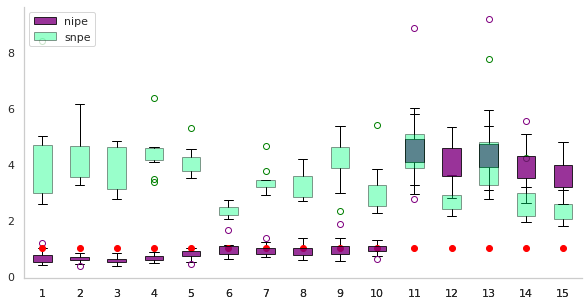

In [199]:
### plot variances:
import seaborn as sns

sns.set_style("whitegrid", {'axes.grid' : False})
#sns.set_context('talk')
sns.set_context('notebook')


figure_mosaic = """
C
"""

fig, axes = plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(10, 5))

nipe = axes['C'].boxplot(nipe_array, patch_artist=True, medianprops = dict(linewidth=0), boxprops=dict(facecolor='purple'),  flierprops=dict(color='purple', markeredgecolor='purple', label='nipe'),
                  )

#nipe = axes['A'].boxplot(nipe_array, patch_artist=True, medianprops = dict(linewidth=0), boxprops=dict(facecolor='purple'),  flierprops=dict(color='purple', markeredgecolor='purple', label='nipe'),
#                 )


snpe_c = axes['C'].boxplot(snpe_array, patch_artist=True, medianprops = dict(linewidth=0),
                  boxprops=dict(facecolor='springgreen'), flierprops=dict(color='springgreen', markeredgecolor='green', label='snpe'),
                  )

for b in snpe_c['boxes']:
    b.set_alpha(0.4)
    
for b in nipe['boxes']:
    b.set_alpha(0.8)
    
axes['C'].plot(np.linspace(1,15, 15), analytic.stddev[0], 'o', c='red', label='analytic')
    


axes['C'].legend([nipe['boxes'][0], snpe_c['boxes'][0]], ['nipe', 'snpe'], loc='upper left')
#axes['A'].legend([nipe['boxes'][0]], [ 'nipe'], loc='upper left')
sns.despine()
sns.set_context('notebook')

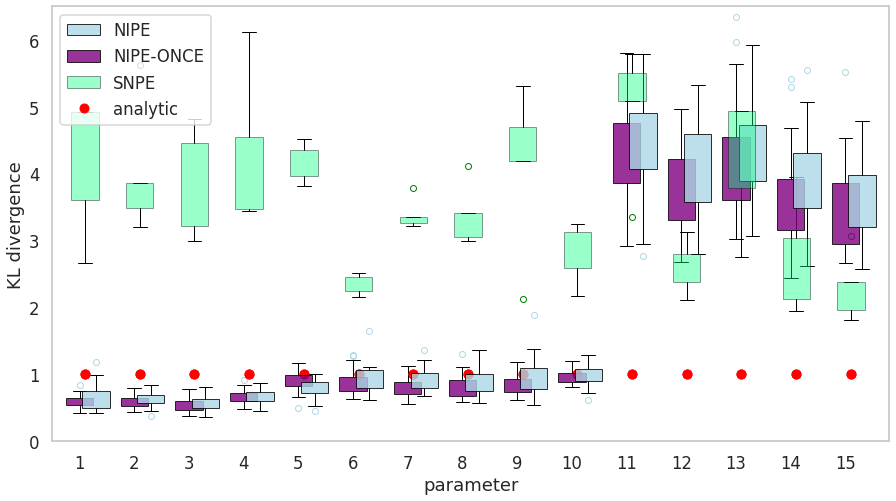

In [193]:
### plot variances:
import seaborn as sns

sns.set_style("whitegrid", {'axes.grid' : False})
#sns.set_context('talk')
sns.set_context('talk')

figure_mosaic = """
ACC
BCC
"""

figure_mosaic = """
C
"""



fig, axes = plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(15, 8))

#axes['A'].plot(variance_list[58],'o', label='nipe', c='blue')

#nipe_box  = axes['A'].boxplot(nipe_noratio_array, patch_artist=True, boxprops=dict(facecolor='lightblue'), medianprops=dict(color='red'),            
#            flierprops=dict(color='lightblue', markeredgecolor='blue'),positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 
#                                                                                 14, 15])
#axes['A'].set(xticklabels=[])
#nipe_ratio_box  = axes['A'].boxplot(nipe_array, patch_artist=True, boxprops=dict(facecolor='blue'), medianprops=dict(color='red'),            
#            flierprops=dict(color='blue', markeredgecolor='blue'),positions=[1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1, 8.1, 9.1, 10.1, 11.1, 12.1, 13.1, 
#                                                                                 14.1, 15.1])

#nipe = axes['A'].boxplot(nipe_array, patch_artist=True, boxprops=dict(facecolor='purple'), medianprops=dict(linewidth=0),            
#            flierprops=dict(color='purple', markeredgecolor='purple'),positions=[1.2, 2.2, 3.2, 4.2, 5.2, 6.2, 7.2, 8.2, 9.2, 10.2, 11.2, 12.2, 13.2, 
  #                                                                               14.2, 15.2])
#axes['A'].set(xticklabels=[])


#axes['A'].set_ylim(0,8)

#snpe_box = axes['B'].boxplot(snpe_array, patch_artist=True, boxprops=dict(facecolor='springgreen'), medianprops=dict(linewidth=0),flierprops=dict(color='green', markeredgecolor='green'),)
#axes['B'].set_ylim(0,8)


#axes['A'].plot(variance_list[59],'o', label='nipe', c='blue')
#axes['A'].plot(variance_list[57],'o', label='nipe', c='blue')


nipe_box = axes['C'].boxplot(nipe_greater_ratio_array, patch_artist=True, medianprops = dict(linewidth=0), boxprops=dict(facecolor='purple'),  flierprops=dict(color='lightblue', markeredgecolor='lightblue'),
                  positions=[0.9, 1.9, 2.9, 3.9, 4.9, 5.9, 6.9, 7.9, 8.9, 9.9, 10.9, 11.9, 12.9, 13.9, 
                                                                                 14.9])


#nipe_ratio_box = axes['C'].boxplot(nipe_less_array, patch_artist=True, medianprops = dict(linewidth=0), boxprops=dict(facecolor='blue'),            
#            flierprops=dict(color='blue', markeredgecolor='blue'),positions=[1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1, 8.1, 9.1, 10.1, 11.1, 12.1, 13.1, 
 #                                                                                14.1, 15.1])

nipe_greater = axes['C'].boxplot(nipe_array, medianprops = dict(linewidth=0),patch_artist=True, boxprops=dict(facecolor='lightblue'),            
            flierprops=dict(color='lightblue', markeredgecolor='lightblue'),positions=[1.2, 2.2, 3.2, 4.2, 5.2, 6.2, 7.2, 8.2, 9.2, 10.2, 11.2, 12.2, 13.2, 
                                                                                 14.2, 15.2])

for b in nipe_greater['boxes']:
    b.set_alpha(0.8)
    
for b in nipe_ratio_box['boxes']:
    b.set_alpha(0.8)

for b in nipe_box['boxes']:
    b.set_alpha(0.8)
    
for b in snpe_box['boxes']:
    b.set_alpha(0.4)
    
    
axes['C'].set(xticklabels=[])

ana_plot = axes['C'].plot(np.linspace(1,15, 15), analytic.stddev[0], 'o', c='red', label='analytic')

    
#axes['B'].plot(np.linspace(1,15, 15), analytic.stddev[0], 'o', c='red', label='analytic')
axes['C'].plot(np.linspace(1,15, 15), analytic.stddev[0], 'o', c='red', label='analytic')

#axes['B'].plot(variance_list_snpe[59],'o', c='g', label = 'snpe')
snpe_c = axes['C'].boxplot(snpe_array, patch_artist=True, medianprops = dict(linewidth=0),
                  boxprops=dict(facecolor='springgreen'), flierprops=dict(color='springgreen', markeredgecolor='green'),
                  )

for b in snpe_c['boxes']:
    b.set_alpha(0.4)
    
axes['C'].set_ylim(0,6.5)

axes['C'].legend()

axes['C'].set_xlabel('parameter')
axes['C'].set_ylabel('KL divergence')

#axes['B'].legend([snpe_box['boxes'][0], ana_plot[0]], ['snpe', 'analytic'], loc='upper left')
#axes['A'].legend([nipe_box['boxes'][0], ana_plot[0]], ['nipe budget1',  'analytic'], loc='upper left')
axes['C'].legend([nipe_greater['boxes'][0],  nipe_box['boxes'][0], snpe_c['boxes'][0], ana_plot[0]], ['NIPE', 'NIPE-ONCE', 'SNPE', 'analytic'], loc='upper left')

In [86]:
nipe_array = torch.stack(([mean_list_inc[i] for i in range(10)]), dim=1)


snpe_array = torch.stack(([mean_list_snpe[i] for i in range(10)]), dim=1)

IndexError: list index out of range

In [25]:
analytic.mean

tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])

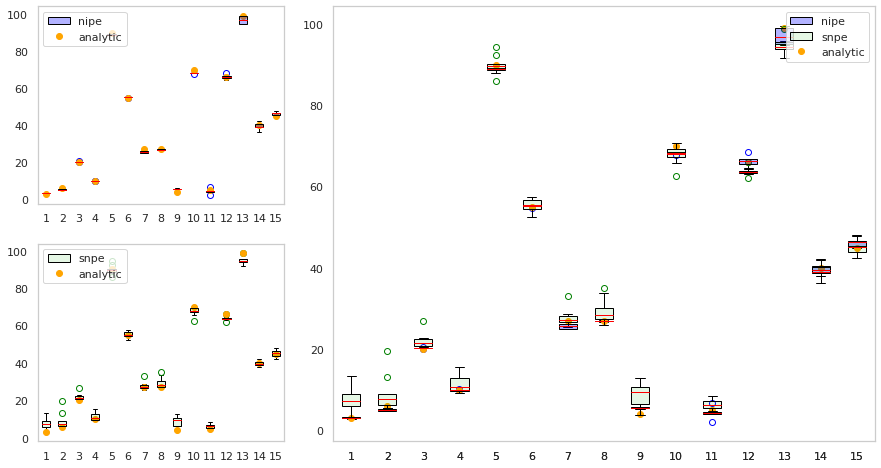

In [85]:
### plot means:
import seaborn as sns

sns.set_style("whitegrid", {'axes.grid' : False})

figure_mosaic = """
ACC
BCC
"""

fig, axes = plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(15, 8))

#axes['A'].plot(variance_list[58],'o', label='nipe', c='blue')

nipe_box  = axes['A'].boxplot(nipe_array, patch_artist=True, boxprops=dict(facecolor='blue'), medianprops=dict(color='red'),            
            flierprops=dict(color='blue', markeredgecolor='blue'))

[patch.set(alpha=None, facecolor=(0.,0.,1,.3)) for patch in nipe_box['boxes']]

#axes['A'].set_ylim(0,15)

snpe_box = axes['B'].boxplot(snpe_array, patch_artist=True, boxprops=dict(facecolor='green'), medianprops=dict(color='red'),flierprops=dict(color='green', markeredgecolor='green'),)
#axes['B'].set_ylim(0,15)

[patch.set(alpha=None, facecolor=(0,0.7,0,.1)) for patch in snpe_box['boxes']]


#axes['A'].plot(variance_list[59],'o', label='nipe', c='blue')
#axes['A'].plot(variance_list[57],'o', label='nipe', c='blue')


nipe_box2 = axes['C'].boxplot(nipe_array, patch_artist=True, boxprops=dict(facecolor='blue'), medianprops=dict(color='red'), flierprops=dict(color='blue', markeredgecolor='blue'),)

ana_plot = axes['A'].plot(np.linspace(1,15, 15), analytic.mean[0], 'o', c='orange', label='analytic')
axes['B'].plot(np.linspace(1,15, 15), analytic.mean[0], 'o', c='orange', label='analytic')
axes['C'].plot(np.linspace(1,15, 15), analytic.mean[0], 'o', c='orange', label='analytic')

#axes['B'].plot(variance_list_snpe[59],'o', c='g', label = 'snpe')
snpe_box2 = axes['C'].boxplot(snpe_array, patch_artist=True, boxprops=dict(facecolor='green'), medianprops=dict(color='red'), flierprops=dict(color='green', markeredgecolor='green'),)
#axes['C'].set_ylim(0,15)

[patch.set(alpha=None, facecolor=(0,0.7,0,.1)) for patch in snpe_box2['boxes']]
[patch.set(alpha=None, facecolor=(0.,0.,1,.3)) for patch in nipe_box2['boxes']]

axes['C'].legend()

axes['B'].legend([snpe_box['boxes'][0], ana_plot[0]], ['snpe', 'analytic'], loc='upper left')
axes['A'].legend([nipe_box['boxes'][0], ana_plot[0]], ['nipe',  'analytic'], loc='upper left')
axes['C'].legend([nipe_box['boxes'][0], snpe_box['boxes'][0], ana_plot[0]], ['nipe', 'snpe', 'analytic'], loc='upper right')